In [30]:
!pip install idx2numpy
import idx2numpy
from google.colab.patches import cv2_imshow
from PIL import Image
import random
import math
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Preprocessing

In [31]:
# dataset import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML

X_train = idx2numpy.convert_from_file('train-images-idx3-ubyte')
Y_train = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
X_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
Y_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

# dropping classes of clothing apart from Trouser and Pullover
def find_pos(data):
    pos = []
    for i in range(len(data)):
        if data[i]!=1 and data[i]!=2:
            pos.append(i)
    return pos

# finding positions of unwanted classes
pos_train = find_pos(Y_train)
pos_test = find_pos(Y_test)

# deleting the unwanted classes of clothing
X_train = np.delete(X_train, tuple(pos_train), axis=0)
Y_train = np.delete(Y_train, tuple(pos_train), axis=0)
X_test = np.delete(X_test, tuple(pos_test), axis=0)
Y_test = np.delete(Y_test, tuple(pos_test), axis=0)

# converting images to 1D arrays
train_num_samples, train_dim1, train_dim2 = X_train.shape
test_num_samples, test_dim1, test_dim2 = X_test.shape
X_train = X_train.reshape(train_num_samples, train_dim1*train_dim2)
X_test = X_test.reshape(test_num_samples, test_dim1*test_dim2)

# binarizing the images
X_train[X_train < 128] = 0
X_train[X_train >= 128] = 255
X_test[X_test < 128] = 0
X_test[X_test >= 128] = 255

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML


# Naive Bayes Classifier


Test accuracy score:  0.933

Test confusion matrix (true trouser, false pullover, false trouser, true pullover): 
[[964  36]
 [ 98 902]]



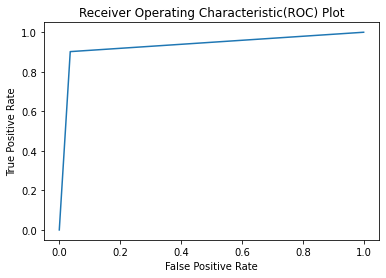


Confusion matrix of fold  1
[[552  26]
 [ 65 557]]
Accuracy of fold  1 :  0.9241666666666667
Precision of fold  1 :  0.8946515397082658
Recall of fold  1 :  0.9550173010380623

Confusion matrix of fold  2
[[568  14]
 [ 61 557]]
Accuracy of fold  2 :  0.9375
Precision of fold  2 :  0.9030206677265501
Recall of fold  2 :  0.9759450171821306

Confusion matrix of fold  3
[[565  26]
 [ 71 538]]
Accuracy of fold  3 :  0.9191666666666667
Precision of fold  3 :  0.8883647798742138
Recall of fold  3 :  0.9560067681895094

Confusion matrix of fold  4
[[584  24]
 [ 63 529]]
Accuracy of fold  4 :  0.9275
Precision of fold  4 :  0.9026275115919629
Recall of fold  4 :  0.9605263157894737

Confusion matrix of fold  5
[[566  25]
 [ 70 539]]
Accuracy of fold  5 :  0.9208333333333333
Precision of fold  5 :  0.889937106918239
Recall of fold  5 :  0.9576988155668359

Confusion matrix of fold  6
[[598  18]
 [ 59 525]]
Accuracy of fold  6 :  0.9358333333333333
Precision of fold  6 :  0.9101978691019786
Rec

In [32]:
# plots the ROC curve
def plot_roc(Y_test, y_pred):
    # converting values to 0-1 for sklearn ROC impleentation
    Y_test[Y_test == 1] = 0
    Y_test[Y_test == 2] = 1
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == 2] = 1
    fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
    # plot of true positive rate and false positive rate
    plt.title('Receiver Operating Characteristic(ROC) Plot')
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# splitting the data into k folds
def k_fold_split(k, input, output):
    input = input.tolist()
    output = output.tolist()
    fold_size = math.floor(len(input) / k)
    x_data_kfolds = []
    y_data_kfolds = []


    for i in range(k):
        x_fold = []
        y_fold = []
        while len(x_fold) < fold_size:
            index = random.randint(0, len(input)-1)
            x_fold.append(input.pop(index))
            y_fold.append(output.pop(index))
        x_data_kfolds.append(x_fold)
        y_data_kfolds.append(y_fold)

    return x_data_kfolds, y_data_kfolds

# calculation of prior values of each class
def calc_prior(labels):
    ctr = len(labels)
    labels = np.array(labels)
    tctr = np.count_nonzero(labels == 1)
    pctr = np.count_nonzero(labels == 2)
    return tctr/ctr, pctr/ctr

# calculation of likelihood values
def calc_likelihood(data, labels):
    num_samples = len(data)
    num_features = len(data[0])
    y1, y2 = np.count_nonzero(labels == 1), np.count_nonzero(labels == 2)
    values1 = []
    # for each feature xi and class yi, finding the conditional probability P(xi | y = yi)
    for i in range(num_features):
        ctr = 0
        for j in range(num_samples):
            if data[j][i] == 255 and labels[j] == 1:
                ctr += 1
        nx0 = num_samples/2 - ctr
        nx1 = ctr
        # calculating probability using a smoothing function to handle zero probabilities
        values1.append([(nx0 + 1)/(y1 + num_features), (nx1 + 1)/ (y1 + num_features)]) 
    values2 = []
    for i in range(num_features):
        ctr = 0
        for j in range(num_samples):
            if data[j][i] == 255 and labels[j] == 2:
                ctr += 1
        nx0 = num_samples/2 - ctr
        nx1 = ctr
        values2.append([(nx0 + 1)/(y2 + num_features), (nx1 + 1)/ (y2 + num_features)])
    return values1, values2

# predicting the posterior values based on priors and likelihood values
def predict(data, prior, likelihoods):
    y1, y2 = prior
    likelihoods1, likelihoods2 = likelihoods
    posterior1 = math.log(y1) 
    posterior2 = math.log(y2)
    y_pred = []
    num_samples = len(data)
    num_features = len(data[0])
    ctr1 = 0
    ctr2  = 0
    for i in range(num_samples):
        posterior1 = math.log(y1)
        posterior2 = math.log(y2)
        for j in range(num_features):
            if data[i][j] == 0:
                posterior1 += math.log(likelihoods1[j][0])  # addition of log values used to prevent underflow
                posterior2 += math.log(likelihoods2[j][0])
            else:
                posterior1 += math.log(likelihoods1[j][1])
                posterior2 += math.log(likelihoods2[j][1])
        # maximising the posterior value
        if posterior1 >= posterior2:
            y_pred.append(1)
            ctr1 += 1
        else:
            y_pred.append(2)
            ctr2 += 1
    return np.array(y_pred)

# implementation over k folds
def cross_validation(k, data_x, data_y):
    num_samples = len(data_x[0])
    results = []
    # repeat for each fold
    for i in range(k):
        x_train = list(data_x)
        y_train = list(data_y)
        x_test = []
        y_test = []
        x_test.append(data_x[i])
        y_test.append(data_y[i])
        x_train.remove(data_x[i])
        y_train.remove(data_y[i])
        x_train = sum(x_train, [])
        y_train = sum(y_train, [])
        prior = calc_prior(y_train)
        likelihoods = calc_likelihood(x_train, y_train)
        y_pred = predict(x_test[0], prior, likelihoods)

        y_test = np.array(y_test[0]).reshape(num_samples, 1)
        y_pred = np.array(y_pred).reshape(num_samples, 1)
        print('\nConfusion matrix of fold ', i+1)
        print(metrics.confusion_matrix(y_test, y_pred))
        accuracy = metrics.accuracy_score(y_test, y_pred)
        print('Accuracy of fold ', i+1, ': ', accuracy)
        precision = metrics.precision_score(y_test, y_pred)
        print('Precision of fold ', i+1, ': ', precision)
        recall = metrics.recall_score(y_test, y_pred)
        print('Recall of fold ', i+1, ': ', recall)
        results.append(accuracy)
    return results

# test accuracy
prior = calc_prior(Y_train)
likelihoods = calc_likelihood(X_train, Y_train)
y_pred = predict(X_test, prior, likelihoods)
accuracy = metrics.accuracy_score(Y_test, y_pred)
print('\nTest accuracy score: ', accuracy)
print('\nTest confusion matrix (true trouser, false pullover, false trouser, true pullover): ')
print(metrics.confusion_matrix(Y_test, y_pred))
print()
plot_roc(Y_test, y_pred)

# k-fold cross validation
random.seed(0)
k = 10
data_x, data_y = k_fold_split(k, X_train, Y_train)
results = cross_validation(k, data_x, data_y)
print('\nAverage accuracy: ', float(sum(results))/len(results))